In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_engine.selection import SmartCorrelatedSelection
import polars as pl


path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

import feature_engineering
from feature_engine.selection import SmartCorrelatedSelection


c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pl.read_csv("..\data\cleaned_df.csv")
callGraph = pl.read_json('..\data\supervised_call_graphs.json')

In [3]:
df.head(3)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,target
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,i64
0,"""1f2c32d8-2d6e-…",0.000812,0.004066,85.643243,5405,"""default""",1460.0,1295.0,451.0,"""E""","""normal""",0
1,"""4c486414-d4f5-…",0.000063,0.002211,16.166805,519,"""default""",9299.0,8447.0,302.0,"""E""","""normal""",0
2,"""7e5838fc-bce1-…",0.004481,0.015324,99.573276,6211,"""default""",255.0,232.0,354.0,"""E""","""normal""",0


In [4]:
callGraph.head(3)

_id,call_graph
str,list[struct[2]]
"""1f2c32d8-2d6e-…","[{""1f873432-6944-3df9-8300-8a3cf9f95b35"",""5862055b-35a6-316a-8e20-3ae20c1763c2""}, {""8955faa9-0e33-37ad-a1dc-f0e640a114c2"",""a4fd6415-1fd4-303e-aa33-bb1830b5d9d4""}, … {""016099ea-6f20-3fec-94cf-f7afa239f398"",""6fa8ad53-2f0d-3f44-8863-139092bfeda9""}]"
"""4c486414-d4f5-…","[{""016099ea-6f20-3fec-94cf-f7afa239f398"",""946e3ced-48a5-3de5-ad5a-1d20b1ab7eb5""}, {""a05a261f-128d-3cd8-a8e1-d6e52e161947"",""375c16ea-5f8d-32d5-8893-639d9b3a53d6""}, … {""68acdde8-bd53-39d1-9be0-fd67a281d7be"",""d7a53acc-eb6e-3f6c-b72e-9aefb54dd311""}]"
"""7e5838fc-bce1-…","[{""1f873432-6944-3df9-8300-8a3cf9f95b35"",""5862055b-35a6-316a-8e20-3ae20c1763c2""}, {""857c4b20-3057-30e0-9ca3-d6f5c3dbe4a6"",""857c4b20-3057-30e0-9ca3-d6f5c3dbe4a6""}, … {""016099ea-6f20-3fec-94cf-f7afa239f398"",""6fa8ad53-2f0d-3f44-8863-139092bfeda9""}]"


**Observation**
* Cleaned data already cotains engineered features

**Impact** 

* Do feature engineering on graph


In [5]:
callsProcessed = callGraph.with_columns(
    pl.col("call_graph").list.eval(
        pl.element().struct.rename_fields(["to", "from"])
    )
).explode("call_graph").unnest("call_graph")
callsProcessed.head(3)

_id,to,from
str,str,str
"""1f2c32d8-2d6e-…","""1f873432-6944-…","""5862055b-35a6-…"
"""1f2c32d8-2d6e-…","""8955faa9-0e33-…","""a4fd6415-1fd4-…"
"""1f2c32d8-2d6e-…","""85754db8-6a55-…","""85754db8-6a55-…"


In [6]:
graph_features = callsProcessed.group_by('_id').agg(
    pl.len().alias('n_connections'),
    pl.col('from'),
    pl.col('to')
).with_columns(
    pl.concat_list('from', 'to').list.unique().list.len().alias('n_unique_nodes')
).select([
    '_id',
    'n_connections',
    'n_unique_nodes'
])

graph_features.sample(3)

_id,n_connections,n_unique_nodes
str,u32,u32
"""33f1ff34-282f-…",1271,231
"""89ba5d2e-d2e0-…",60,29
"""1b5a3503-ac22-…",22,11


In [7]:
calls_processed = callsProcessed.with_columns(
    global_source_degrees = pl.len().over(pl.col('from')),
    global_dest_degrees = pl.len().over(pl.col('to')),
    local_source_degrees = pl.len().over(pl.col('from'), pl.col('_id')),
    local_dest_degrees = pl.len().over(pl.col('to'), pl.col('_id'))
)

calls_processed.sample(3)

_id,to,from,global_source_degrees,global_dest_degrees,local_source_degrees,local_dest_degrees
str,str,str,u32,u32,u32,u32
"""cb02407e-18e7-…","""fdf9315c-87d2-…","""61593699-2829-…",6883,509,2,2
"""9ccc904d-bf3a-…","""bc60534d-50e2-…","""f55c447d-c81b-…",2529,1905,9,8
"""add84c84-0918-…","""d7a53acc-eb6e-…","""ceadb050-358d-…",2447,2230,2,7


In [8]:
node_features_agg = feature_engineering.aggregate_node_features(
    calls_processed,
    node_features=[
        "global_source_degrees",
        "global_dest_degrees",
        "local_source_degrees",
        "local_dest_degrees",
    ],
    by="_id",
)

graph_features = graph_features.join(node_features_agg, on="_id")
graph_features.head(5)

_id,n_connections,n_unique_nodes,avg_global_source_degrees,min_global_source_degrees,max_global_source_degrees,std_global_source_degrees,avg_global_dest_degrees,min_global_dest_degrees,max_global_dest_degrees,std_global_dest_degrees,avg_local_source_degrees,min_local_source_degrees,max_local_source_degrees,std_local_source_degrees,avg_local_dest_degrees,min_local_dest_degrees,max_local_dest_degrees,std_local_dest_degrees
str,u32,u32,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64
"""2d13060e-d7d4-…",73,33,9426.027397,355,22416,8486.924325,9940.027397,311,32071,10695.470894,5.383562,1,12,4.188709,5.60274,1,13,4.81531
"""f1dd44ae-381f-…",17,10,5311.941176,813,22416,7809.305447,8002.823529,403,32071,11824.023455,2.411765,1,4,1.121318,2.176471,1,3,0.727607
"""f5c9c155-bb12-…",37,19,526.540541,1,1151,438.821376,348.675676,71,596,166.256337,4.297297,1,8,2.866132,3.540541,1,6,1.520135
"""1054ffc4-31f9-…",18,10,739.611111,7,1151,382.737837,403.777778,236,596,143.673468,4.777778,1,7,2.263666,2.888889,1,5,1.450715
"""7fd83042-81e2-…",16,10,11098.0,842,22013,9299.837174,15647.9375,911,32071,13399.967584,2.25,1,4,1.290994,3.125,1,6,2.334524


# Feature Selection

In [9]:
engineered_features = graph_features.columns[1:]
engineered_features

['n_connections',
 'n_unique_nodes',
 'avg_global_source_degrees',
 'min_global_source_degrees',
 'max_global_source_degrees',
 'std_global_source_degrees',
 'avg_global_dest_degrees',
 'min_global_dest_degrees',
 'max_global_dest_degrees',
 'std_global_dest_degrees',
 'avg_local_source_degrees',
 'min_local_source_degrees',
 'max_local_source_degrees',
 'std_local_source_degrees',
 'avg_local_dest_degrees',
 'min_local_dest_degrees',
 'max_local_dest_degrees',
 'std_local_dest_degrees']

In [10]:
null_counts = graph_features.null_count().transpose(include_header=True, header_name='col', column_names=['null_count'])
null_counts.filter(pl.col('null_count') > 0)

col,null_count
str,u32
"""std_global_sou…",42
"""std_global_des…",42
"""std_local_sour…",42
"""std_local_dest…",42


# Correlation Analysis

<Axes: >

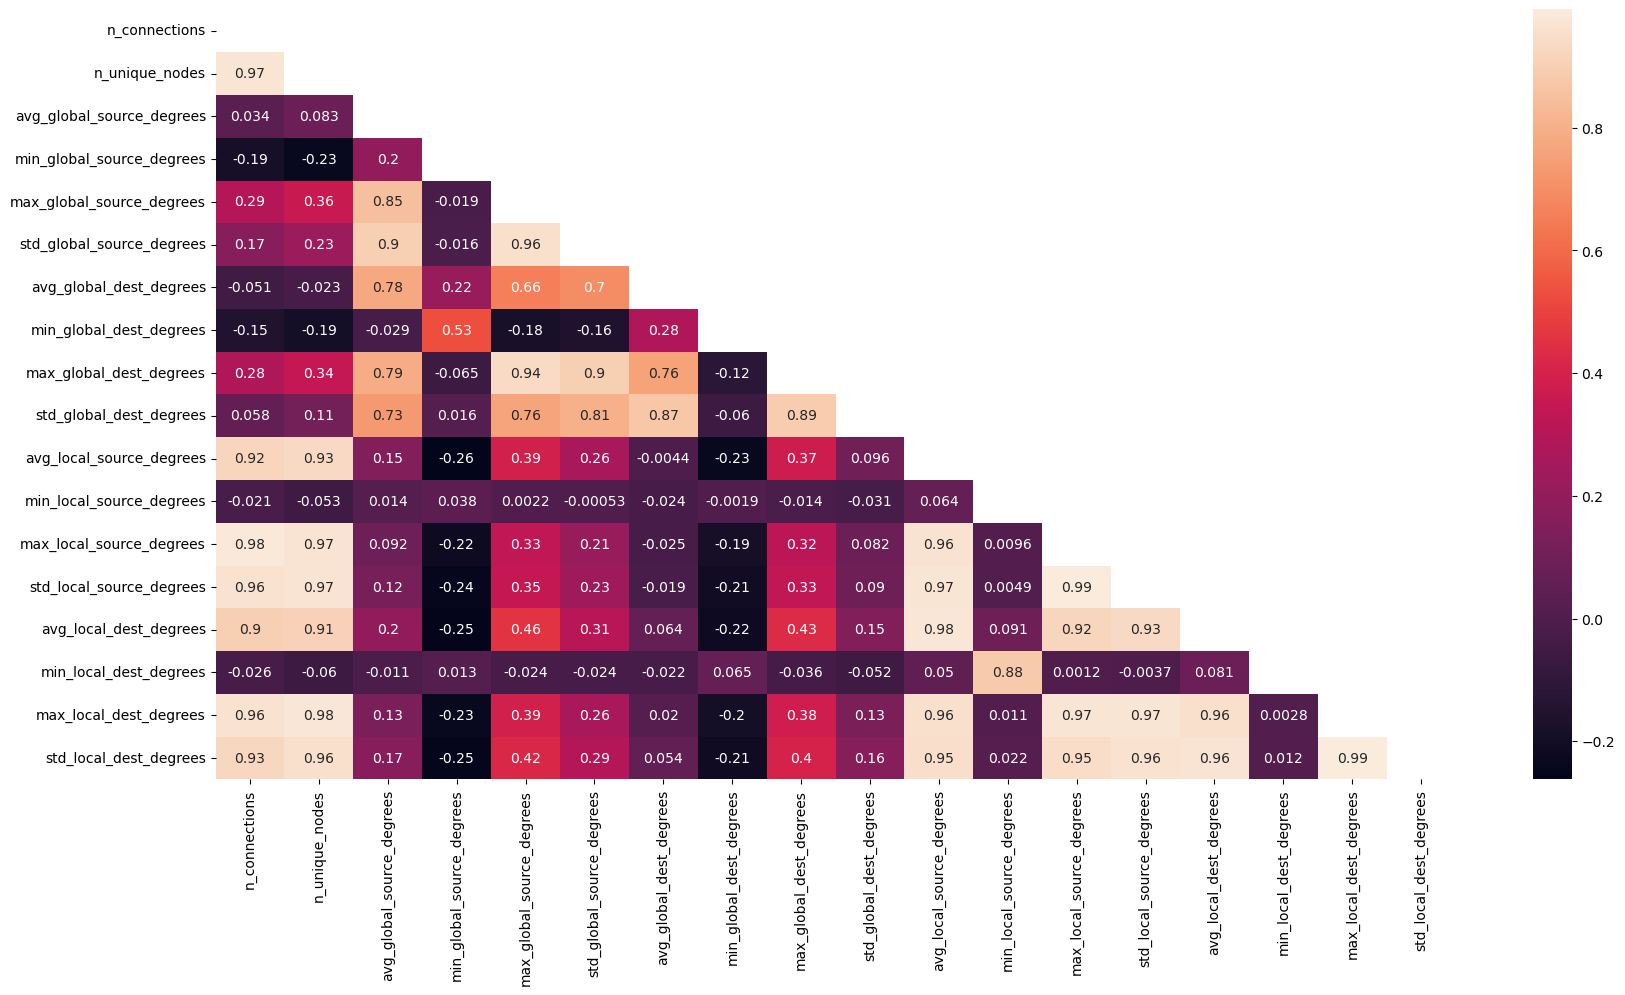

In [11]:
feature_corrs = graph_features.select(engineered_features).to_pandas().dropna().corr()
feature_corrs.index = feature_corrs.columns
matrix = np.triu(feature_corrs)
fig = plt.figure(figsize=(20, 10))
sns.heatmap(feature_corrs, annot=True, mask=matrix)

Lets use SmartCorrelationSelection to drop features

In [12]:
features_pd = graph_features.select(engineered_features).to_pandas().dropna()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.95,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

tr.fit(features_pd)

print('Features to drop:')
for f in tr.features_to_drop_:
    print(f)

Features to drop:
std_global_source_degrees
n_unique_nodes
max_local_dest_degrees
max_local_source_degrees
std_local_source_degrees
avg_local_source_degrees
avg_local_dest_degrees


**Observations:**

* Engineered features have groups of high correlation

**Impact**

* ['n_unique_nodes', 'std_global_dest_degrees', 'avg_local_source_degrees', 'max_local_source_degrees', 'avg_local_dest_degrees', 'max_local_dest_degrees' 'std_local_dest_degrees'] are dropped from the features list due to belonging to a high correlation set and having lower variance than the remaining feature